# Optimisation - Final Exam

rc47878

In [1]:
!pip install gurobipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gurobipy as gb

import tensorflow as tf
from tqdm import tqdm

from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

GUROBI_TIMEOUT = 5 # in second

%matplotlib inline

# CNN

(Q2 - Q5)

In [3]:
# problem 1

# Read the data
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()
#normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0 

ndata_train = x_train.shape[0]
ndata_test = x_test.shape[0]

print(x_train.shape, x_test.shape, y_test.shape, y_train.shape, ndata_train, ndata_test) 

# Initialize the model architecture
NNmodel = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=15,kernel_size=(3,3), activation=tf.nn.relu, input_shape=x_train.shape[1:]),
        tf.keras.layers.Conv2D(filters=20,kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.Conv2D(filters=25,kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.Conv2D(filters=30,kernel_size=(3,3), activation=tf.nn.relu),      
        tf.keras.layers.MaxPooling2D(pool_size = (2,2),strides=2),
        tf.keras.layers.Conv2D(filters=20,kernel_size=(4,4),activation=tf.nn.relu),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(512,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(128,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(32,activation=tf.nn.relu),
        tf.keras.layers.Dense(10,activation=tf.nn.softmax),
        ])

# Compile the model
NNmodel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

NNmodel.summary()


NNmodel.fit(x_train,y_train,epochs=15,batch_size=128)

pred_probs = NNmodel.predict(x_test)
pred = np.argmax(pred_probs, axis=1)
print(np.mean(pred==y_test))

(50000, 32, 32, 3) (10000, 32, 32, 3) (10000, 1) (50000, 1) 50000 10000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 15)        420       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 20)        2720      
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 25)        4525      
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 30)        6780      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 30)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 20)     

In [17]:
## Predict the class of test data and calculate accuracy
pred_probs = NNmodel.predict(x_test)
mask = np.argmax(pred_probs, axis=1)==y_test.flatten()
print('Accuracy: ', round(np.count_nonzero(mask == True)/len(x_test),3))

Accuracy:  0.685


In [ ]:
# thus 0.69

# Die Roll

( Q10 - Q13 )

In [5]:
def die_simulation(stop_limit: int, ngames:int = 100000)->np.array:
  scores= []
  for i in range(100000):
    sc = 0
    while sc <= stop_limit:
      sc += np.random.randint(1,7)
    if sc > 7:
      sc = 0
    scores.append(sc)
  return np.array(scores)

In [6]:
# Keep throwing dice as long as score is >= 4
np.round(np.mean(die_simulation(stop_limit= 4)), 1)

4.4

In [7]:
for stop_limit in range(2,6):
  print(f'Stopping if score >={stop_limit+1}:', np.round(np.mean(die_simulation(stop_limit= stop_limit)), 1))

Stopping if score >=3: 4.5
Stopping if score >=4: 4.7
Stopping if score >=5: 4.4
Stopping if score >=6: 3.5


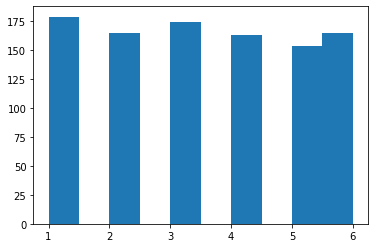

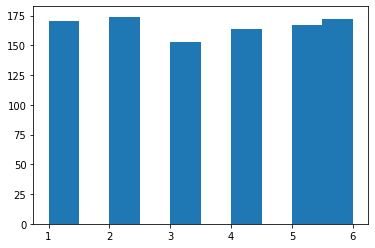

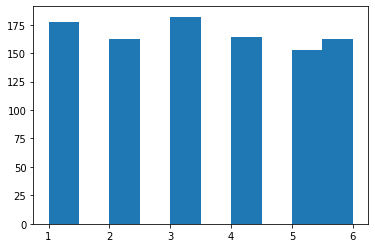

In [8]:
plt.hist([np.random.choice(6)+1 for i in range(1000)])
plt.show()

plt.hist([np.random.choice(range(1,7)) for i in range(1000)])
plt.show()

plt.hist([np.random.choice([1,2,3,4,5,6]) for i in range(1000)])
plt.show()

# Mining

( Q17 - Q18 )

In [9]:
def fun(x):
    return -(price*x - np.exp(x/4)/np.sqrt(1+s) + delta*cs(s-x))

In [10]:
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
price = 5 # price per ton sold
M = 150 # current tons in mine
delta = 0.94 # discount rate
T = 25 # years with a lease

sValues = np.arange(M+1) # all possible levels of ore in mine
tValues = np.arange(T+1) # get to mine in years 0-14, in year 15 mine shuts down

sN = len(sValues) # how many s and t values are there?
tN = len(tValues)

V = np.zeros((sN,tN)) # value function
U = np.zeros((sN,tN)) # place to store optimal number of tons to mine

V[:,tN-1] = 0 # terminal condition value function.. this is a bit redundant because of lines above, but it's worth repeating!
U[:,tN-1] = 0 # terminal tons of ore to mine

for ti in reversed(range(tN-1)): # loop backwards in time
    # create a cubic spline for tomorrow's value function
    cs = CubicSpline(sValues,V[:,ti+1])
    for si in range(sN): # loop over all possible tons of ore in mine
        t=tValues[ti] # what is the actual time and tons in the mine
        s=sValues[si] 
        
        # do some NLP to get the optimal x
        opt = minimize(fun,[s/2.0], method='L-BFGS-B', bounds=[(0,s)], tol=1e-8)
        V[si,ti] = -opt.fun[0] # pick the one that maximizes that value
        U[si,ti] = opt.x[0]

In [11]:
s=M # at the initial time there are 100 tons of ore
for t in range(T):
    si= int(s)
    print(f"Year: {t}, Ore remaining: {round(s,1)}; Mined: {round(U[si,t], 1)}")
    s -= U[si,t] # remove this amount from the mine


Year: 0, Ore remaining: 150; Mined: 18.6
Year: 1, Ore remaining: 131.4; Mined: 18.0
Year: 2, Ore remaining: 113.4; Mined: 17.4
Year: 3, Ore remaining: 96.0; Mined: 16.7
Year: 4, Ore remaining: 79.3; Mined: 15.8
Year: 5, Ore remaining: 63.5; Mined: 14.8
Year: 6, Ore remaining: 48.7; Mined: 13.6
Year: 7, Ore remaining: 35.1; Mined: 12.2
Year: 8, Ore remaining: 22.9; Mined: 10.1
Year: 9, Ore remaining: 12.8; Mined: 7.5
Year: 10, Ore remaining: 5.2; Mined: 4.0
Year: 11, Ore remaining: 1.3; Mined: 0.4
Year: 12, Ore remaining: 0.9; Mined: 0.0
Year: 13, Ore remaining: 0.9; Mined: 0.0
Year: 14, Ore remaining: 0.9; Mined: 0.0
Year: 15, Ore remaining: 0.9; Mined: 0.0
Year: 16, Ore remaining: 0.9; Mined: 0.0
Year: 17, Ore remaining: 0.9; Mined: 0.0
Year: 18, Ore remaining: 0.9; Mined: 0.0
Year: 19, Ore remaining: 0.9; Mined: 0.0
Year: 20, Ore remaining: 0.9; Mined: 0.0
Year: 21, Ore remaining: 0.9; Mined: 0.0
Year: 22, Ore remaining: 0.9; Mined: 0.0
Year: 23, Ore remaining: 0.9; Mined: 0.0
Year: 

# cVar

( Q6 - Q9 )

In [12]:
# Helper Functions

class Gurobi_Model():
    '''
        Class Method I made to help me encapsulate the whole Gurobi model creation, 
        Finding Slack Variable and perform sensitivity analysis
    '''
    
    def __init__(self, obj_linear, cons, sense, b, variable_types = 'C',
                lower_bound = None, upper_bound = None,
                optimisation_type = gb.GRB.MAXIMIZE, obj_quadratic = None) -> None:
        '''
            Initialising the Model
        '''
        if (obj_quadratic is None) and (obj_linear is None):
            raise Exception("No objective defined")

        constraints, variables = cons.shape

        ## Optimisation Model at work (Maximise)
        try:
            self.model = gb.Model()
            self.model_X = self.model.addMVar(variables,
                                        vtype=variable_types,
                                        lb= lower_bound, ub= upper_bound)

            self.model_constraints = self.model.addMConstr(cons, self.model_X, sense, b)
            self.model.setMObjective(obj_quadratic, obj_linear, 0, sense=optimisation_type)
            self.model.Params.OutputFlag = 0
            self.model.Params.TimeLimit = GUROBI_TIMEOUT

            self.model.optimize()

        except Exception:
            print("Error in optimising")
            raise Exception
        
        ## Assigning stuff for other use cases
        try:
            self.obj_q = obj_quadratic
            self.obj = obj_linear
            self.constraint = cons
            self.sense = sense
            self.b = b
        except Exception:
            print("Error in Storing equations")
            raise Exception
        return

    @property
    def optimal_obj(self): return self.model.objVal

    @property
    def optimal_x(self): return self.model_X.x

    @property
    def output(self):
        return {'objVal': self.optimal_obj,
                'x': self.optimal_x}

    def print_equations(self)->None:
        '''
            Print Objective Functions and Constraint Equations
        '''
        char = "a"
        print("Optimise System of equations:")
        for item in self.obj:
            print(str(item)+char,end=" + ")
            char = chr(ord(char) + 1)
        print("\b\b")
        print("Subject to:")#, end=" ")
        for i in range(self.constraint.shape[0]):
            char = "a"
            print("\t"+str(i)+")",end=" ")
            for j in range(self.constraint.shape[1]):
                print(str(self.constraint[i,j])+char,end=" + ")
                char = chr(ord(char) + 1)
            print("\b\b "+self.sense[i]+"= "+str(self.b[i]))
        return


In [13]:
beta = 0.05
stocks = pd.read_csv('stock_data.csv')
stocks


,Stock1,Stock2,Stock3,Stock4,Stock5,Stock6,Stock7,Stock8,Stock9,Stock10
0,-0.0115,-0.0319,-0.0055,0.0299,-0.0009,-0.0196,0.0466,0.0393,-0.0147,0.0233
1,0.0018,0.0294,0.0080,-0.0093,-0.0022,-0.0039,0.0327,-0.0059,0.0074,-0.0362
2,0.0163,-0.0027,0.0166,0.0117,-0.0027,-0.0149,0.0055,0.0143,-0.0078,0.0078
3,0.0191,-0.0089,0.0020,0.0355,-0.0059,-0.0049,0.0323,0.0332,0.0174,0.0314
4,0.0100,0.0201,0.0039,-0.0253,-0.0049,0.0167,0.0188,0.0478,0.0076,-0.0186
...,...,...,...,...,...,...,...,...,...,...
95,-0.0078,0.0217,-0.0089,0.0135,-0.0090,-0.0238,0.0342,-0.0070,0.0117,-0.0188
96,0.0176,-0.0003,0.0000,0.0070,0.0226,0.0232,-0.0036,-0.0005,-0.0060,-0.0224
97,-0.0247,-0.0128,-0.0221,-0.0059,-0.0111,-0.0049,-0.0231,0.0008,-0.0080,0.0150
98,-0.0157,0.0103,0.0152,-0.0252,0.0182,-0.0115,-0.0012,0.0253,-0.0147,-0.0333


In [14]:
num_days, num_stocks = stocks.shape

obj = np.array([1] + [1/(num_days*beta)]*(num_days) + [0]*(num_stocks))
variables = obj.shape[0]
constraints = num_days + 1 # +1 cause sum of w's = 1

A = np.zeros((constraints, variables))
b = np.zeros(constraints)
sense = np.array(['>']*(constraints-1)+['='])

lb = np.array([-np.inf] + [0]*(variables-1))

for day in range(0,num_days):
    A[day, 0] = 1 # alpha
    A[day, day+1] = 1 # h
    A[day, num_days+1:] =  stocks.loc[day]# r
    b[day] = 0

A[-1,-num_stocks:] = 1
b[-1] = 1

A.shape, b.shape, sense.shape
# A

((101, 111), (101,), (101,))

In [15]:
model_1 = Gurobi_Model(obj_linear= obj,
                        cons= A,
                        sense= sense,
                        b = b,
                        lower_bound= lb,
                        variable_types=['C']*variables,
                        optimisation_type= gb.GRB.MINIMIZE)
# model_1.print_equations()
print(f'Opimal cVar: {round(model_1.optimal_obj, 3)}')


Restricted license - for non-production use only - expires 2023-10-25
Opimal cVar: 0.007
